# Simple `MF6ADJ` demonstration

In this notebook, we will quickly run through some standard usage of `MF6ADJ` to calculate sensitivities to a few different performance measures.  We will of course be using the Freyberg model

In [1]:
import os
import platform
import sys
import shutil
from datetime import datetime
import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import flopy
import pyemu

First we need to get the platform-specific binaries.  We have some strict control over these and they are stored at the root level in the repo in the `bin` dir.  Let's workout what path we should be using and the binary names we need:

In [2]:
if "linux" in platform.platform().lower():
    lib_name = os.path.join("..", "bin", "linux", "libmf6.so")
    mf6_bin = os.path.join("..", "bin", "linux", "mf6")
    local_lib_name = "./libmf6.so"
    local_mf6_bin = "./mf6"
    gg_bin = os.path.join("..", "bin", "linux", "gridgen")
elif "darwin" in platform.platform().lower() or "macos" in platform.platform().lower() and "arm" not in platform.platform().lower():
    lib_name = os.path.join("..", "bin", "mac", "libmf6.dylib")
    mf6_bin = os.path.join("..", "bin", "mac", "mf6")
    local_lib_name = "./libmf6.dylib"
    local_mf6_bin = "./mf6"
    gg_bin = os.path.join("..", "bin", "mac", "gridgen")
elif "darwin" in platform.platform().lower() or "macos" in platform.platform().lower() and "arm" in platform.platform().lower():
    lib_name = os.path.join("..", "bin", "mac", "libmf6_arm.dylib")
    mf6_bin = os.path.join("..", "bin", "mac", "mf6")
    local_lib_name = "./libmf6_arm.dylib"
    local_mf6_bin = "./mf6"
    gg_bin = os.path.join("..", "bin", "mac", "gridgen")
else:
    lib_name = os.path.join("..", "bin", "win", "libmf6.dll")
    mf6_bin = os.path.join("..", "bin", "win", "mf6.exe")
    local_lib_name = "libmf6.dll"
    local_mf6_bin = "mf6.exe"
    gg_bin = os.path.join("..", "bin", "win", "gridgen.exe")

In [3]:
lib_name

'../bin/mac/libmf6_arm.dylib'

In [4]:
assert os.path.exists(lib_name)
assert os.path.exists(mf6_bin)

Now let's get the model files we will be using - they are stored in the autotest directory

In [5]:
org_ws = os.path.join("..","autotest","freyberg_structured")
assert os.path.exists(org_ws)

setup a local copy of the model files.  Also copy in the binaries we need for later....

In [6]:
ws = "freyberg"
if os.path.exists(ws):
    shutil.rmtree(ws)
shutil.copytree(org_ws,ws)
shutil.copy2(lib_name,os.path.join(ws,os.path.split(local_lib_name)[1]))
shutil.copy2(mf6_bin,os.path.join(ws,os.path.split(local_mf6_bin)[1]))
shutil.copytree(os.path.join('..','autotest','xmipy'), os.path.join(ws, 'xmipy'))
shutil.copytree(os.path.join('..','autotest','bmipy'), os.path.join(ws, 'bmipy'))
shutil.copytree(os.path.join('..','autotest','modflowapi'), os.path.join(ws, 'modflowapi'))
shutil.copytree(os.path.join('..','autotest','flopy'), os.path.join(ws, 'flopy'))
shutil.copytree(os.path.join('..','mf6adj'), os.path.join(ws,"mf6adj"))

'freyberg/mf6adj'

In [7]:
sim = flopy.mf6.MFSimulation.load(sim_ws=ws)
m = sim.get_model()

loading simulation...
  loading simulation name file...
  loading tdis package...
  loading model gwf6...
    loading package dis...
    loading package ic...
    loading package npf...
    loading package sto...
    loading package oc...
    loading package wel...
    loading package rch...
    loading package ghb...
    loading package sfr...
    loading package obs...
  loading solution package freyberg6...


In [8]:
ib = m.dis.idomain.array[0,:,:].astype(float)
ib[ib>0] = np.nan
ib_cmap = plt.get_cmap("Greys_r")
ib_cmap.set_bad(alpha=0.0)
def plot_model(arr,units=None):
    arr[~np.isnan(ib)] = np.nan
    fig,ax = plt.subplots(1,1,figsize=(6,6))
    cb = ax.imshow(arr,cmap="plasma")
    plt.colorbar(cb,ax=ax,label=units)
    plt.imshow(ib,cmap=ib_cmap)
    return fig,ax

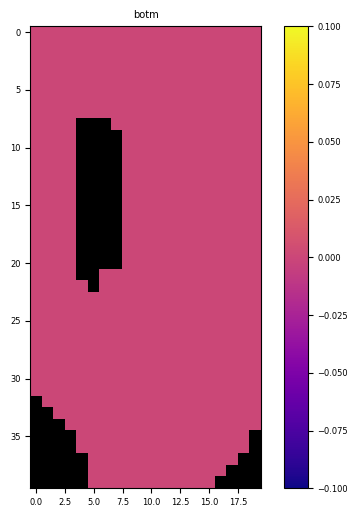

In [9]:
fig,ax = plot_model(m.dis.botm.array[-1,:,:])
_ = ax.set_title("botm")

Run the existing model in our local workspace

In [10]:
pyemu.os_utils.run(local_mf6_bin,cwd=ws)

                                   MODFLOW 6
                U.S. GEOLOGICAL SURVEY MODULAR HYDROLOGIC MODEL
                            VERSION 6.5.0 05/23/2024

   MODFLOW 6 compiled Jun 21 2024 02:59:05 with Intel(R) Fortran Intel(R) 64
   Compiler Classic for applications running on Intel(R) 64, Version 2021.7.0
                             Build 20220726_000000

This software has been approved for release by the U.S. Geological 
Survey (USGS). Although the software has been subjected to rigorous 
review, the USGS reserves the right to update the software as needed 
pursuant to further analysis and review. No warranty, expressed or 
implied, is made by the USGS or the U.S. Government as to the 
functionality of the software and related material nor shall the 
fact of release constitute any such warranty. Furthermore, the 
software is released on condition that neither the USGS nor the U.S. 
Government shall be held liable for any damages resulting from its 
authorized or unauthoriz

Now plot some heads...

Text(0.5, 1.0, 'layer 1 final heads')

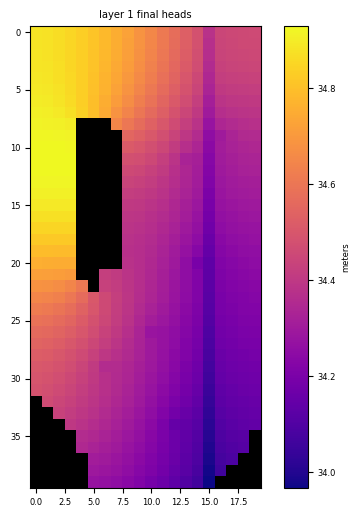

In [11]:
hds = flopy.utils.HeadFile(os.path.join(ws,"freyberg6_freyberg.hds"))
final_arr = hds.get_data()
fig,ax = plot_model(final_arr[0,:,:],units="meters")
ax.set_title("layer 1 final heads")

Ah so nice!  see the sfr "network" running north-south in the 15th column?

The main requirement to use `Mf6Adj` is an input file that describes the performance measures.  Luckily this file has a nice modern format like other MF6 input files.  Here we are going to make one programmatically and also, while doing so, describe the various performance measure formats that are supported...

In [12]:
pm_fname = "freyberg_perfmeas.dat"
fpm = open(os.path.join(ws,pm_fname),'w')


The simpliest type of performance measure is a single simulated head at one place for one simulation time.  Lets make one of those:

In [13]:
l,r,c = 1,5,5 # the layer row and column
sp,ts = 24,1 #stress period and time step
pm_name = "pm_single"
fpm.write("begin performance_measure {0}\n".format(pm_name))
fpm.write("{0} {1} {2} {3} {4} head direct 1.0 -1e30\n".format(sp,ts,l,r,c))
fpm.write("end performance_measure\n\n")

25

Thats it!  we did it.  The complicated line in the "performance measure record" that tells `MF6ADJ` the spatial and temporal information it needs and also tells it about the type of performance measure ("head") and also what form of performance measure we want ("direct" or "residual").  The final two entries are the "weight" and the observered value (which is not used for "direct" form performance measures but must be supplied with any valid floating point value)


Now lets make a more complex "direct" form performance measure - using the same l-r-c but across all simulation times:

In [14]:
l,r,c = 1,5,5 # the layer row and column
pm_name = "pm_single_alltimes"
fpm.write("begin performance_measure {0}\n".format(pm_name))
for kper in range(sim.tdis.nper.data):
    fpm.write("{0} {1} {2} {3} {4} head direct 1.0 -1e30\n".format(kper+1,ts,l,r,c))
fpm.write("end performance_measure\n\n")

25

Boom!

Now lets kick it up a notch and make a "residual" form performance measure, which is a sum-of-squared weighted residual performance measure...to use the form, we need "observed values" so lets just make some noisey simulated values.  Let's use all the l-r-c locations in the MF6 head obs package.  Im sure you can get these from flopy somehow, but I've never been smart enough to figure that out...

In [15]:
lrcs = []
k_dict = {}
with open(os.path.join(ws,"head.obs"),'r') as f:
    f.readline()
    for line in f:
        if line.strip().lower().startswith("end"):
            break
        raw = line.strip().split()
        lrcs.append(" ".join(raw[2:]))
        k = int(raw[2]) - 1
        i = int(raw[3]) - 1
        j = int(raw[4]) - 1
        if k not in k_dict:
            k_dict[k] = []
        k_dict[k].append([i,j])

In [16]:
np.random.seed(11111)
nper = sim.tdis.nper.data
obs_vals = {}
for lrc in lrcs:
    kij = [int(i)-1 for i in lrc.split()]
    vals = final_arr[kij[0],kij[1],kij[2]] + np.random.normal(0,1,nper)
    obs_vals[lrc] = vals

In [17]:
pm_name = "pm_ssr"
fpm.write("begin performance_measure {0}\n".format(pm_name))
for kper in range(kper):
    for lrc in lrcs:
        fpm.write("{0} {1} {2} head residual 1.0 {3}\n".format(kper+1,ts,lrc,obs_vals[lrc][kper]))
fpm.write("end performance_measure\n\n")

25

And now for something really exciting!  `MF6ADJ` also support so-called "flux-based" performance measures, which yield the sensitivity of a simulated flux to the model inputs.  This flux-based performance measure can be described very granularly just like the head-based performance measures.  So lets look at the sensitivity of the simulated sw-gw flux between the groundwater system and sfr during the 23rd stress period (which is a dry time)...we will use the two `boundname` groupings in the sfr inputs

In [18]:
sfr_data = pd.DataFrame.from_records(m.sfr.packagedata.array)
bnames = sfr_data.boundname.unique()
bnames.sort()
sp = 23
for bname in bnames:
    bdf = sfr_data.loc[sfr_data.boundname==bname,:].copy()
    fpm.write("begin performance_measure {0}\n".format(bname))
    for kij in bdf.cellid.values:
        fpm.write("{0} 1 {1} {2} {3} sfr_1 direct 1.0 -1.0e+30\n".format(23,kij[0]+1,kij[1]+1,kij[2]+1))
    fpm.write("end performance_measure\n\n")

Now we snuck in something new there - see that `sfr_1` on the record line? that is the name of the boundary package in the MF6 GWF name file.  `MF6ADJ` also support WEL, GHB, RIV, and CHD for flux based performance measures

In [19]:
fpm.close()

Ok, now we should be ready to go...the adjoint solution process requires running the model forward once and then solving for the adjoint state, which uses the forward solution components (i.e. the conductance matrix, the RHS, heads, saturation,etc). The adjoint state solution has two important characteristics:  its a linear (independent of the forward model's linearity) and it solves backward in time, starting with the last stress period - WAT?!

In [20]:
bd = os.getcwd()
os.chdir(ws)

In [21]:
forward_hdf5_name = "forward.hdf5"
start = datetime.now()
import mf6adj
adj = mf6adj.Mf6Adj(pm_fname,os.path.split(local_lib_name)[1],verbose_level=2)
adj.solve_gwf(hdf5_name=forward_hdf5_name) # solve the standard forward solution
dfsum = adj.solve_adjoint() # solve the adjoint state for each performance measure
adj.finalize() #release components
duration = (datetime.now() - start).total_seconds()
print("took:",duration)

...structured grid found
...starting flow solution at 2024-08-02 11:16:40
flow stress period,time step 1,1 converged with 12 iters, took 0.00079928 mins
flow stress period,time step 2,1 converged with 4 iters, took 0.00018052 mins
flow stress period,time step 3,1 converged with 3 iters, took 0.00022952 mins
flow stress period,time step 4,1 converged with 3 iters, took 0.00012258 mins
flow stress period,time step 5,1 converged with 3 iters, took 0.00011458 mins
flow stress period,time step 6,1 converged with 4 iters, took 0.00013912 mins
flow stress period,time step 7,1 converged with 4 iters, took 0.00017888 mins
flow stress period,time step 8,1 converged with 5 iters, took 0.00018177 mins
flow stress period,time step 9,1 converged with 5 iters, took 0.00015485 mins
flow stress period,time step 10,1 converged with 4 iters, took 0.00013308 mins
flow stress period,time step 11,1 converged with 5 iters, took 0.00017883 mins
flow stress period,time step 12,1 converged with 3 iters, took 0.

In [22]:
os.chdir(bd)

Boo ya!  done...let's see what happened...

In [23]:
[f for f in os.listdir(ws) if f.endswith("hdf5")]

['adjoint_solution_pm_ssr_forward.hdf5',
 'adjoint_solution_headwater_forward.hdf5',
 'adjoint_solution_pm_single_alltimes_forward.hdf5',
 'forward.hdf5',
 'adjoint_solution_tailwater_forward.hdf5',
 'adjoint_solution_pm_single_forward.hdf5']

`MF6ADJ` uses the widely available HDF5 format to store information - these files hold very low-level granular information about the adjoint solution.  However the `mf6adj.solve_adjoint()` method also returns a higher-level summary of the adjoint solution.  Let's look at it first:

In [24]:
type(dfsum)

dict

In [25]:
list(dfsum.keys())

['pm_single', 'pm_single_alltimes', 'pm_ssr', 'headwater', 'tailwater']

In [26]:
dfhw = dfsum["tailwater"]
dfhw

,k11,k33,wel6_q,rch6_recharge,ghb-1_bhead,ghb-1_cond,sfr_1_stage,sfr_1_cond,ss
node,,,,,,,,,
1,-6.080291e-07,-0.000161,-0.003008,-0.003008,0.000000,0.000000,0.0,0.0,0.149142
2,-3.451760e-06,-0.000161,-0.003040,-0.003040,0.000000,0.000000,0.0,0.0,0.171359
3,-8.746567e-06,-0.000161,-0.003104,-0.003104,0.000000,0.000000,0.0,0.0,0.215075
4,-1.572289e-05,-0.000161,-0.003197,-0.003197,0.000000,0.000000,0.0,0.0,0.278895
5,-2.316711e-05,-0.000162,-0.003317,-0.003317,0.000000,0.000000,0.0,0.0,0.362303
...,...,...,...,...,...,...,...,...,...
2392,-1.845777e-02,0.000205,-0.189114,-0.189114,124.054429,-16.465124,0.0,0.0,356.835173
2393,-2.384926e-02,0.000206,-0.222096,-0.222096,123.889522,-15.659132,0.0,0.0,421.367394
2394,-3.141928e-02,0.000199,-0.263049,-0.263049,123.684754,-14.796555,0.0,0.0,491.444683


those are the node-scale sensitivities to the sfr flux-based performance measure - some plots would be nice you say?!  Well this is most easily done with the HDF5 file itself...

In [27]:
result_hdf = "adjoint_solution_headwater_forward.hdf5"
hdf = h5py.File(os.path.join(ws,result_hdf),'r')
keys = list(hdf.keys())
keys.sort()
print(keys)

['composite', 'solution_kper:00000_kstp:00000', 'solution_kper:00001_kstp:00000', 'solution_kper:00002_kstp:00000', 'solution_kper:00003_kstp:00000', 'solution_kper:00004_kstp:00000', 'solution_kper:00005_kstp:00000', 'solution_kper:00006_kstp:00000', 'solution_kper:00007_kstp:00000', 'solution_kper:00008_kstp:00000', 'solution_kper:00009_kstp:00000', 'solution_kper:00010_kstp:00000', 'solution_kper:00011_kstp:00000', 'solution_kper:00012_kstp:00000', 'solution_kper:00013_kstp:00000', 'solution_kper:00014_kstp:00000', 'solution_kper:00015_kstp:00000', 'solution_kper:00016_kstp:00000', 'solution_kper:00017_kstp:00000', 'solution_kper:00018_kstp:00000', 'solution_kper:00019_kstp:00000', 'solution_kper:00020_kstp:00000', 'solution_kper:00021_kstp:00000', 'solution_kper:00022_kstp:00000', 'solution_kper:00023_kstp:00000', 'solution_kper:00024_kstp:00000']


The "composite" group has the sensitivities of the performance measure to the model inputs summed across all adjoint solutions...

In [28]:
grp = hdf["composite"]
plot_keys = [i for i in grp.keys() if len(grp[i].shape) == 3]
plot_keys

['ghb-1_bhead',
 'ghb-1_cond',
 'k11',
 'k33',
 'rch6_recharge',
 'sfr_1_cond',
 'sfr_1_stage',
 'ss',
 'wel6_q']

A simple routine to plot all these sensitivities....

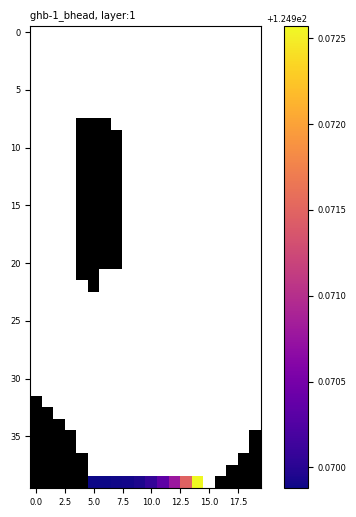

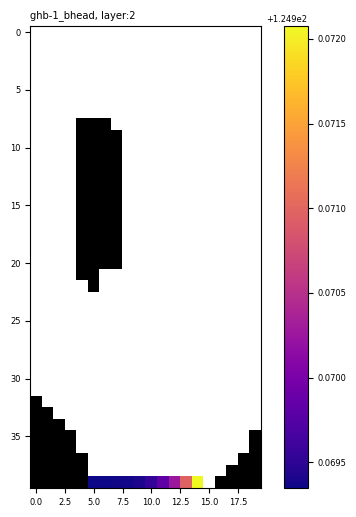

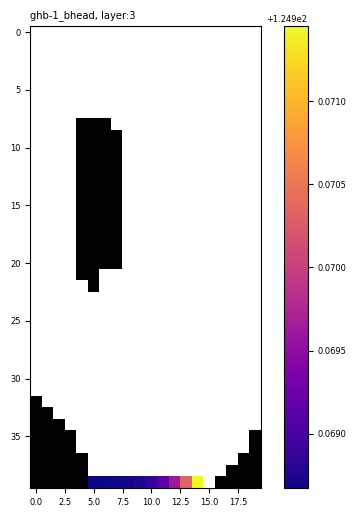

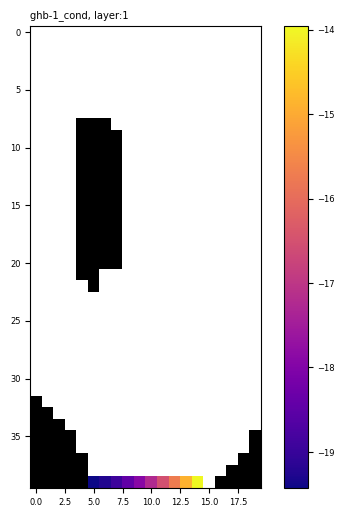

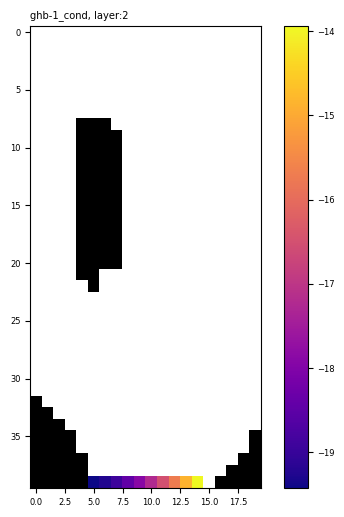

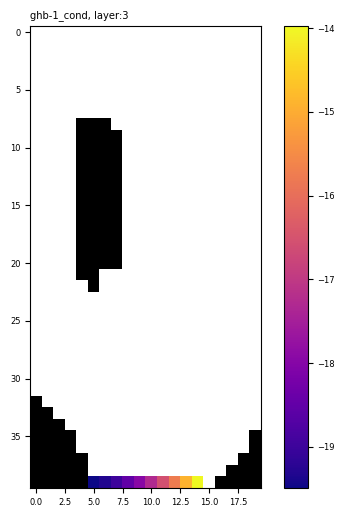

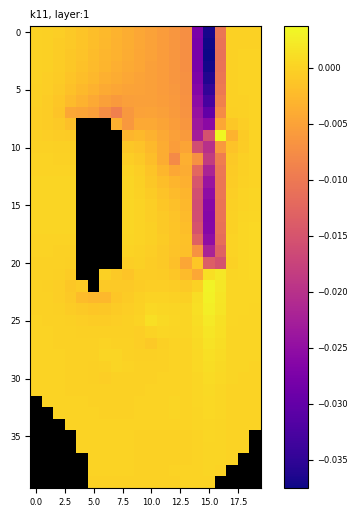

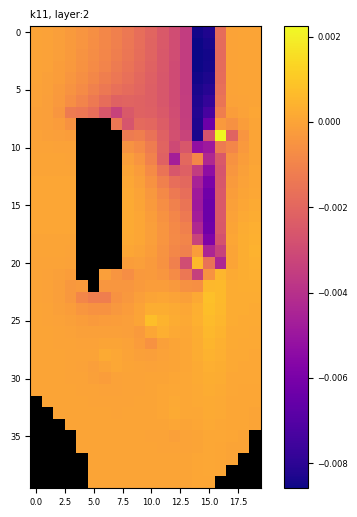

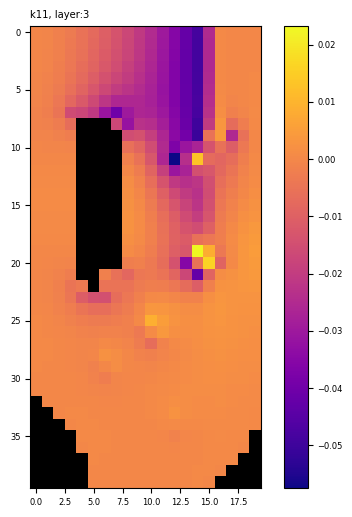

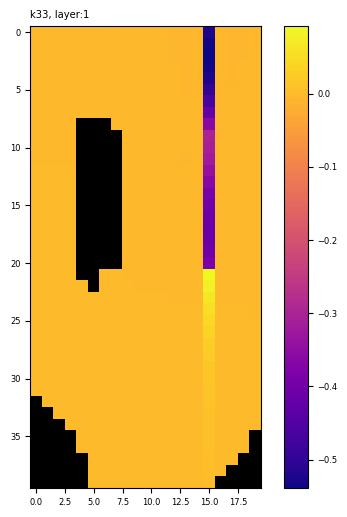

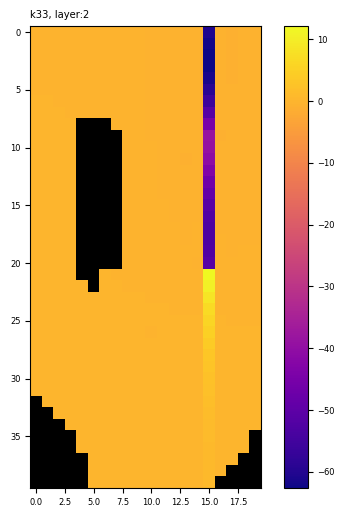

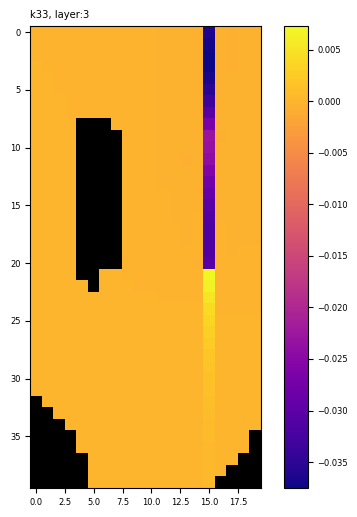

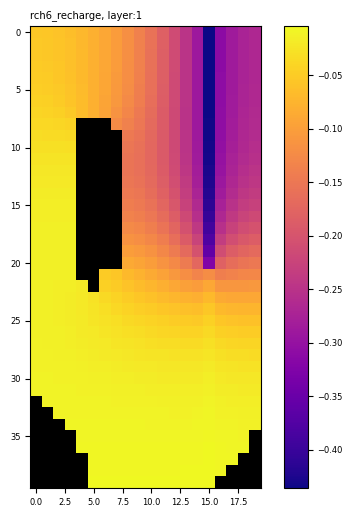

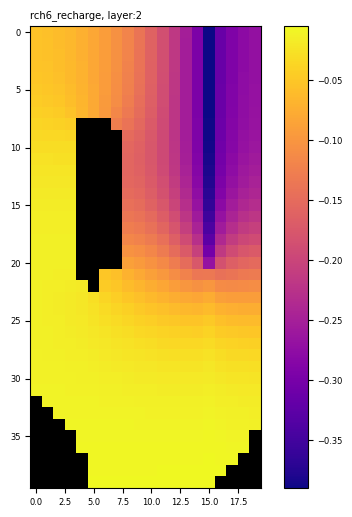

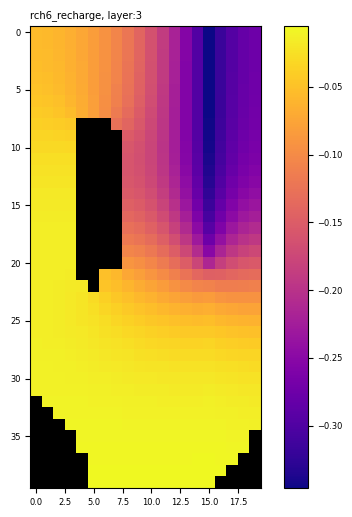

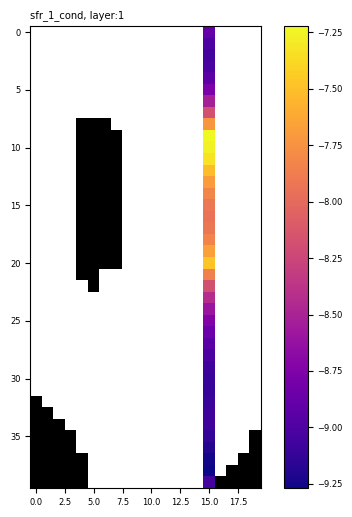

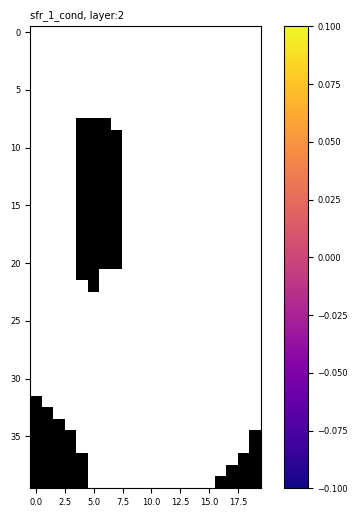

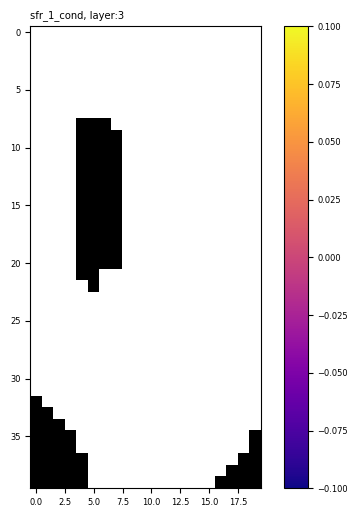

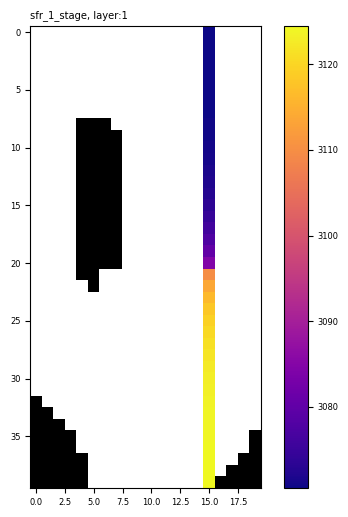

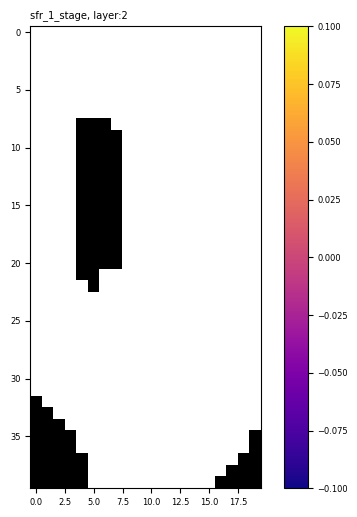

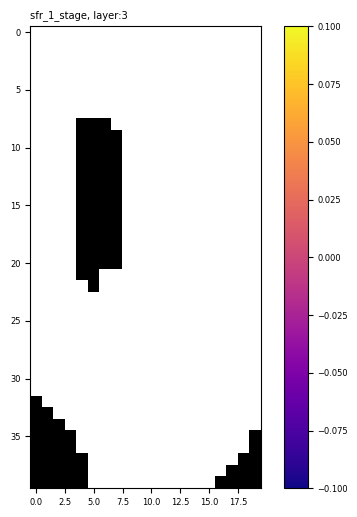

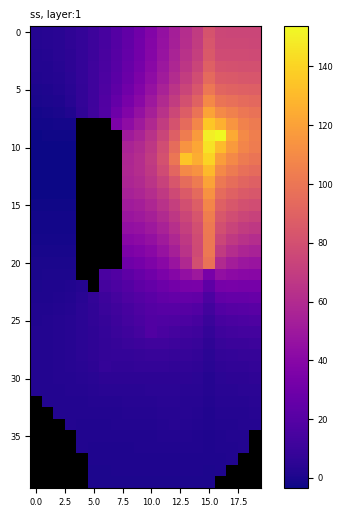

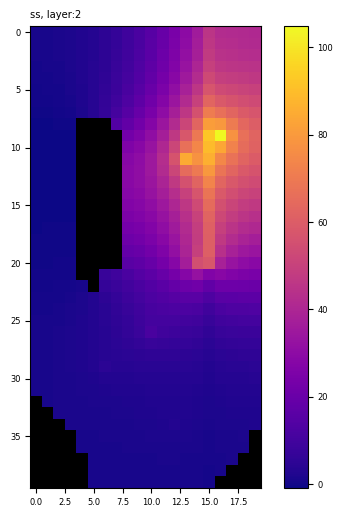

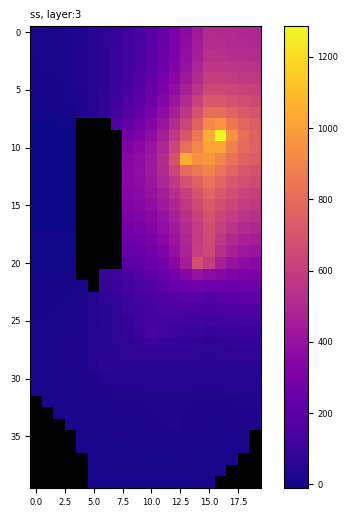

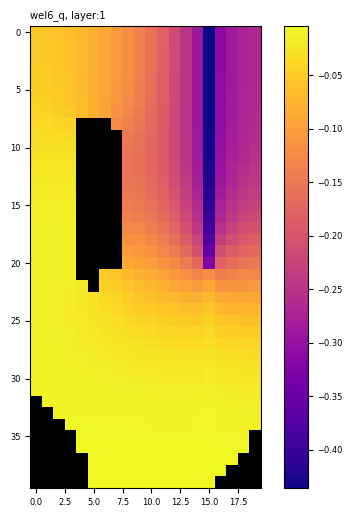

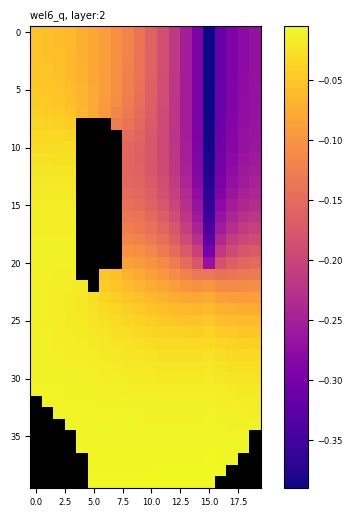

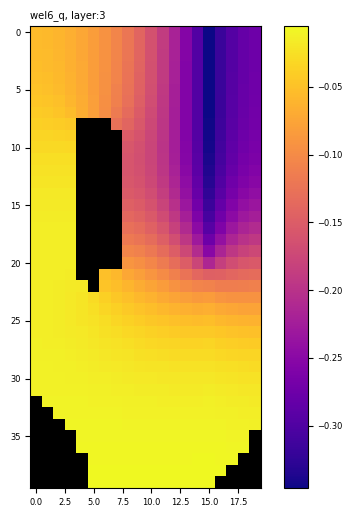

In [29]:
for pkey in plot_keys:
    arr = grp[pkey][:]
    for k,karr in enumerate(arr):
        karr[karr==0.0] = np.nan
        fig,ax = plot_model(karr)
        ax.set_title(pkey+", layer:{0}".format(k+1),loc="left")

what sorcery is this?! How can we have the sensitivity to WEL type boundaries in every model cell when there are only a handful of WEL type boundaries?  And whats the redic business about recharge in layers 2 and 3?!  Well! The adjoint state that we solve for is actuall the sensitivity of the performance measure to a unit injection of water in every active model cell - thats just a WEL type boundary sensitivity.  And recharge is the same quantity scaled by cell area.  How cool is that?! Effectively, those "wel6_q" plots are capture fraction maps for the headwater sfr reaches.  And that only took a few seconds to calculate!  Boo ya!

We can do similar plots for the other performance measures.  Here are the sensitivities to the single head performance measure

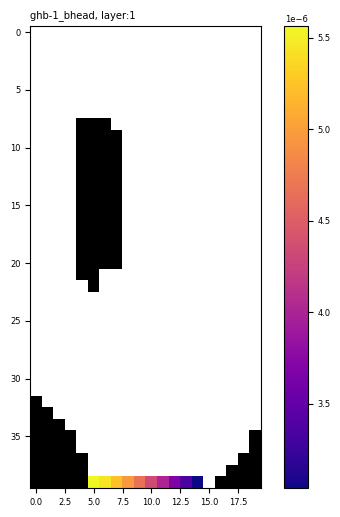

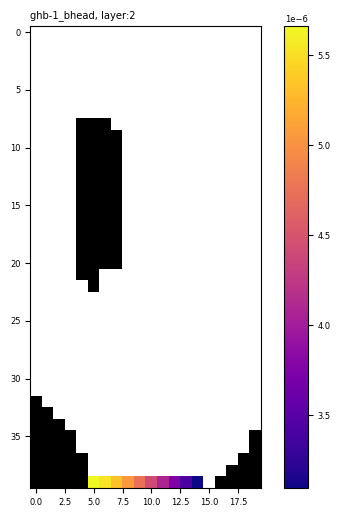

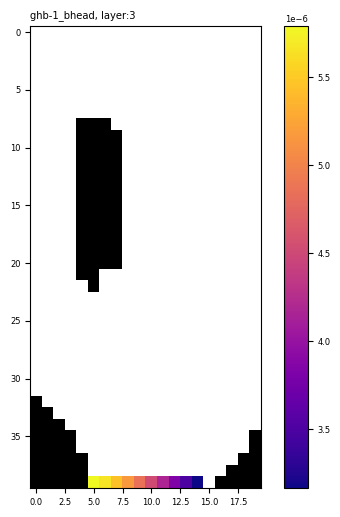

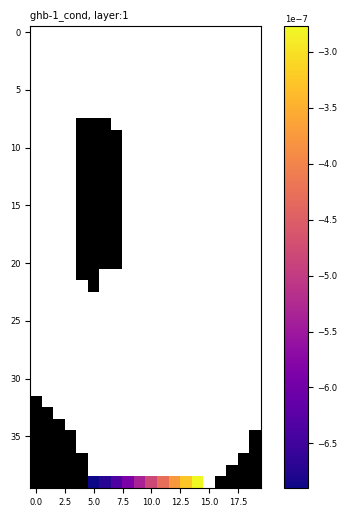

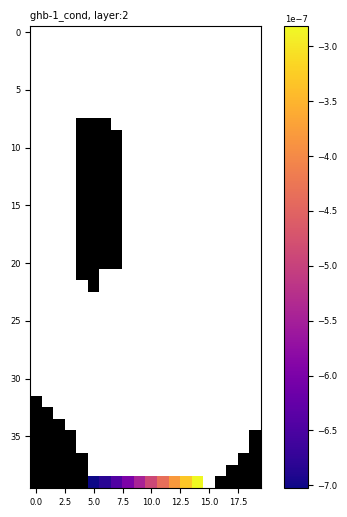

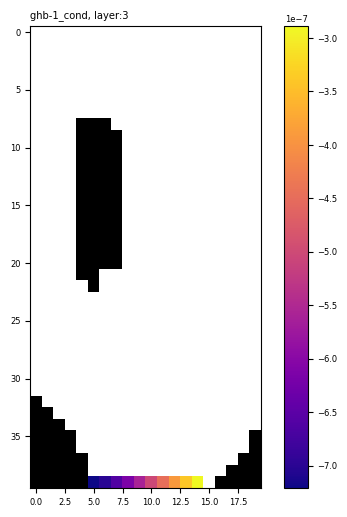

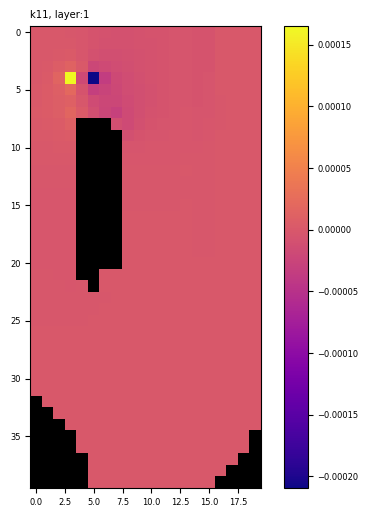

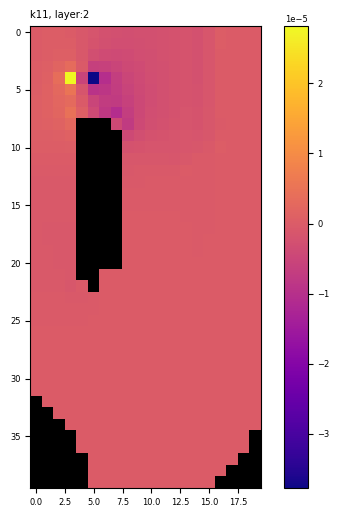

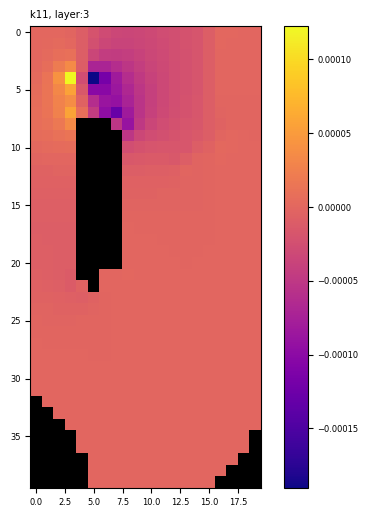

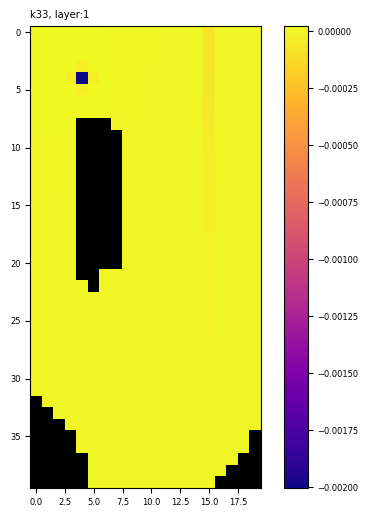

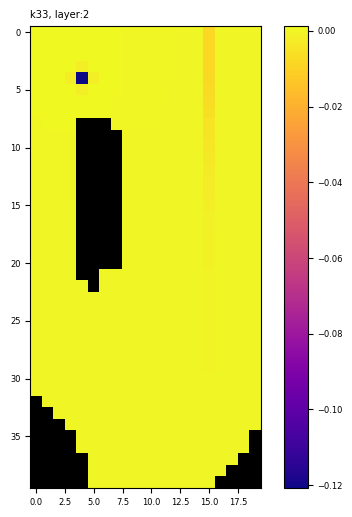

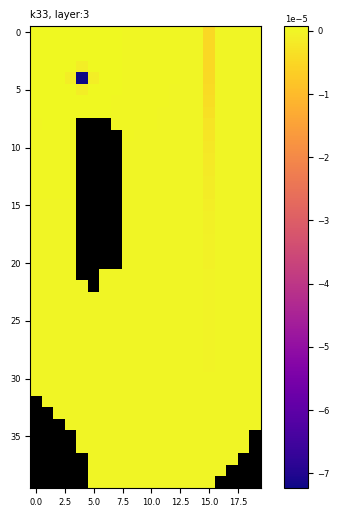

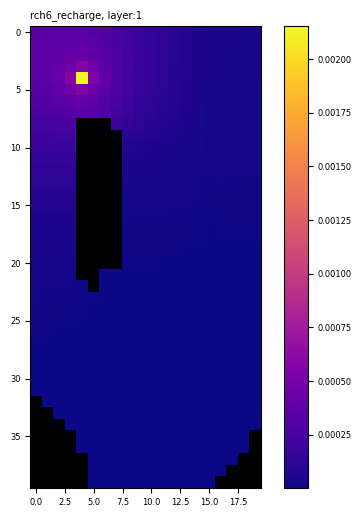

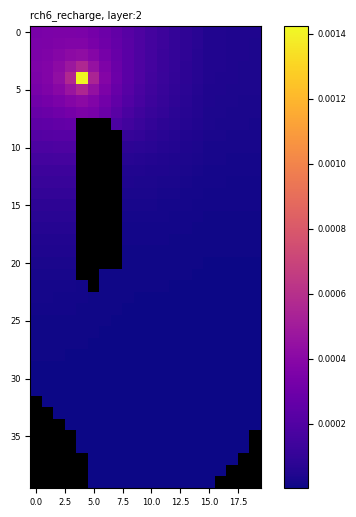

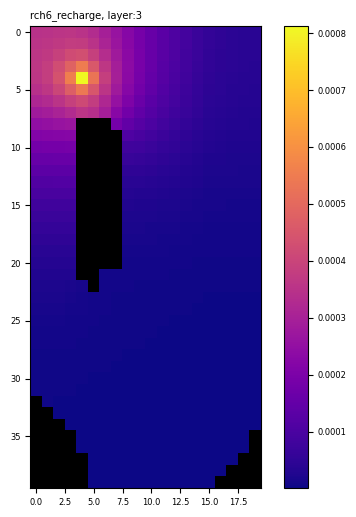

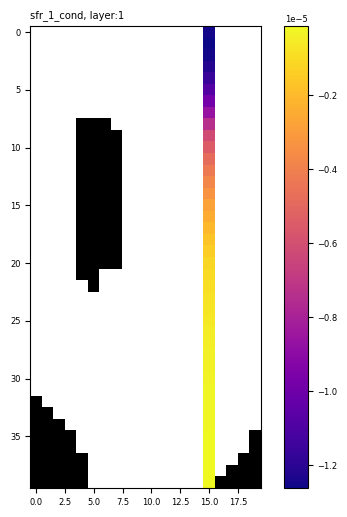

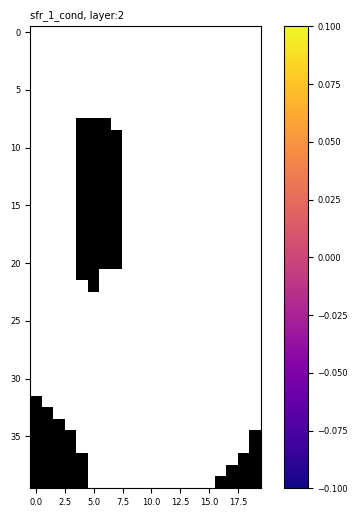

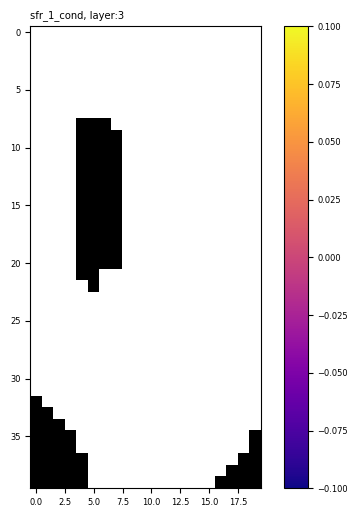

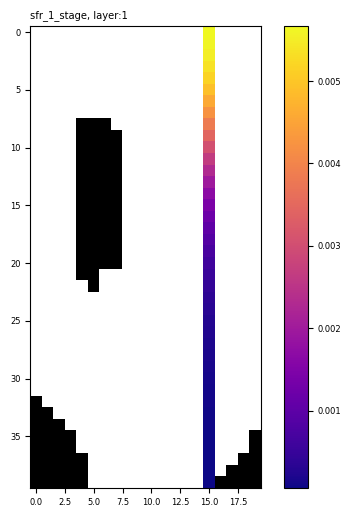

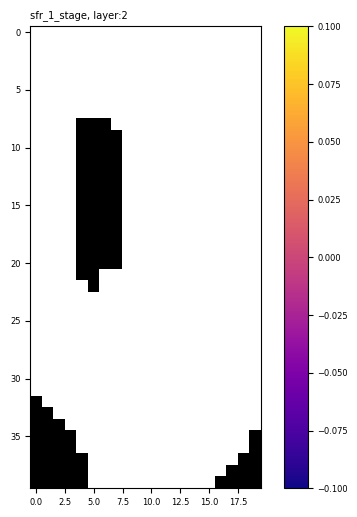

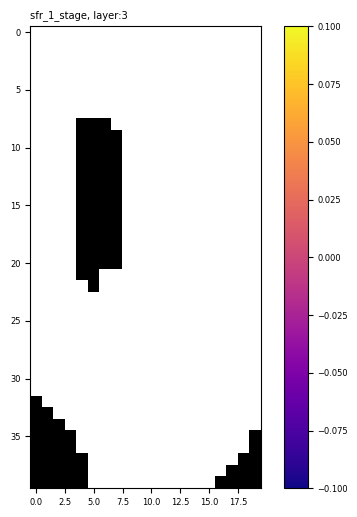

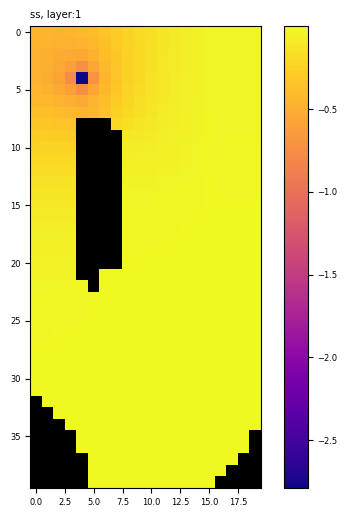

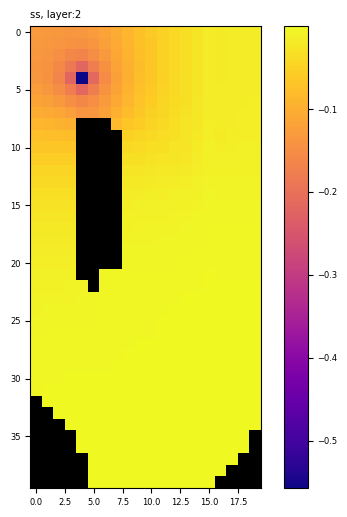

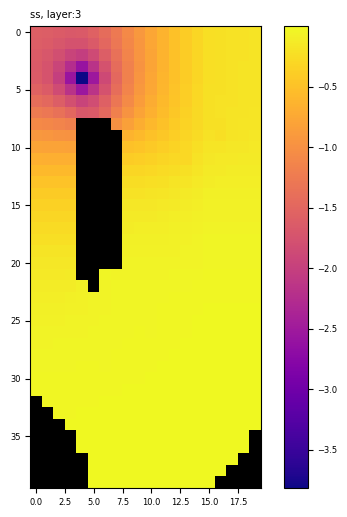

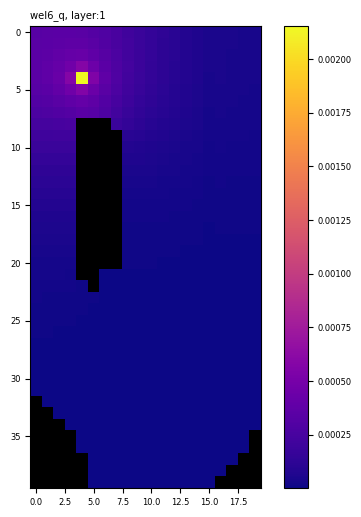

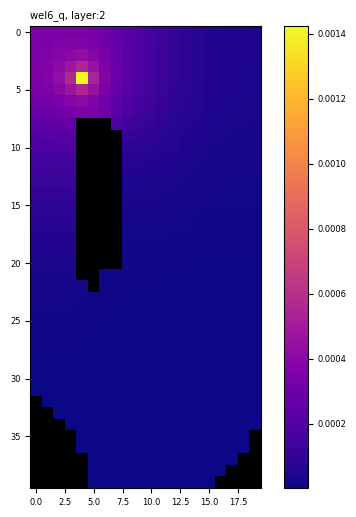

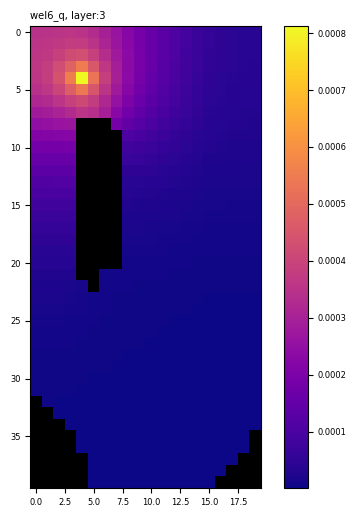

In [32]:
result_hdf = "adjoint_solution_pm_single_forward.hdf5"
hdf = h5py.File(os.path.join(ws,result_hdf),'r')
keys = list(hdf.keys())
grp = hdf["composite"]
plot_keys = [i for i in grp.keys() if len(grp[i].shape) == 3]
for pkey in plot_keys:
    arr = grp[pkey][:]
    for k,karr in enumerate(arr):
        karr[karr==0.0] = np.nan
        fig,ax = plot_model(karr)
        ax.set_title(pkey+", layer:{0}".format(k+1),loc="left")

And here's the sensitvities for the sum-of-squared-weighted residuals

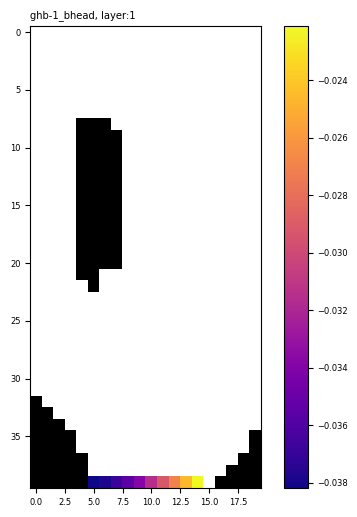

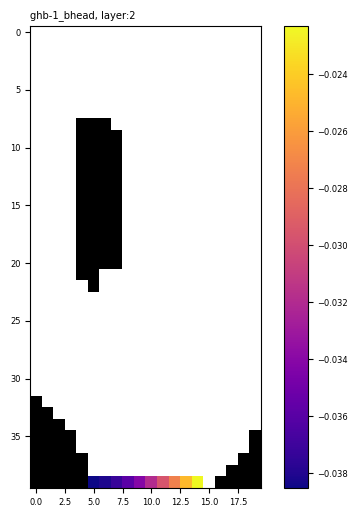

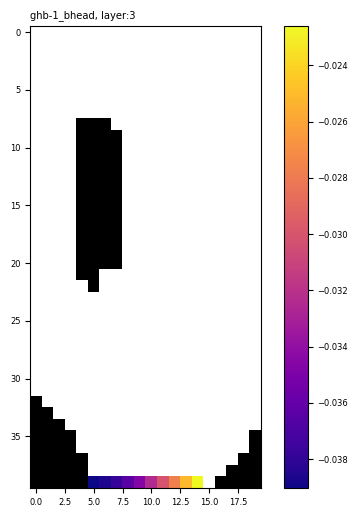

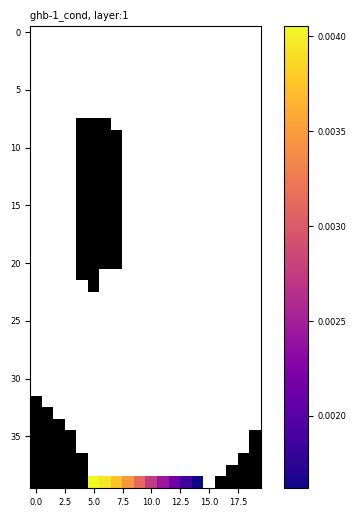

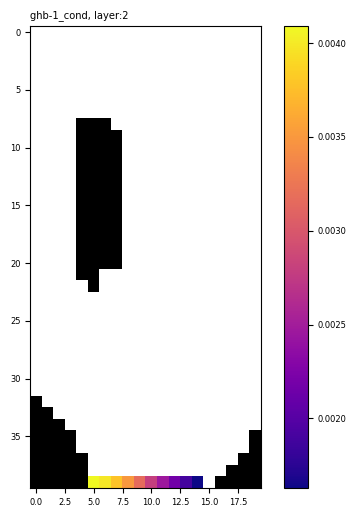

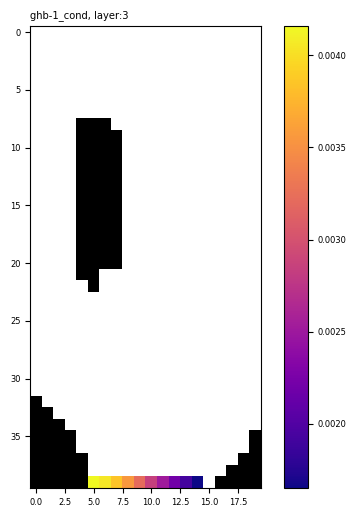

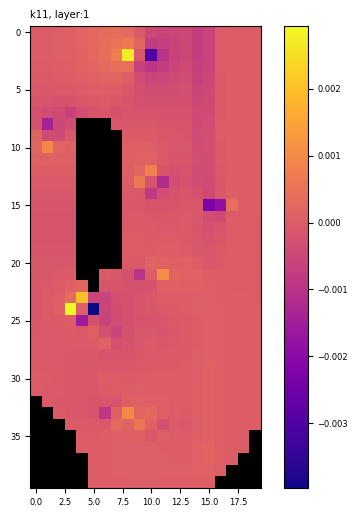

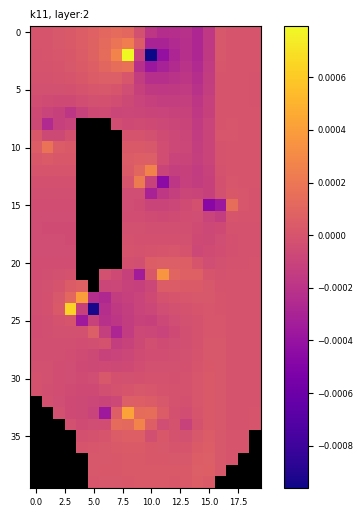

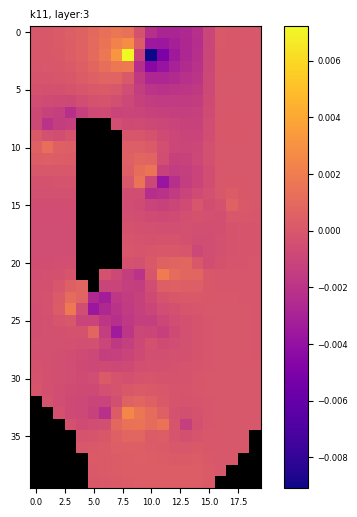

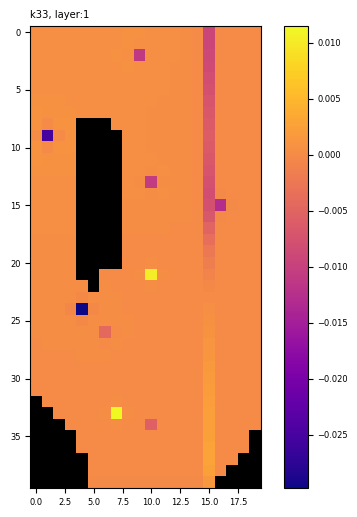

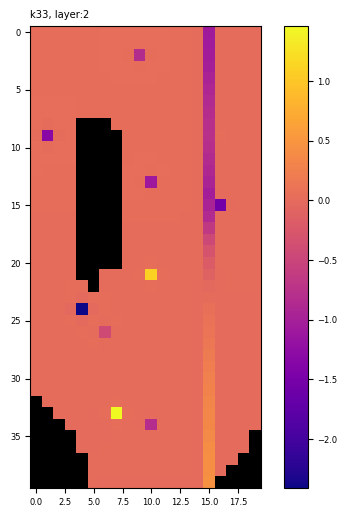

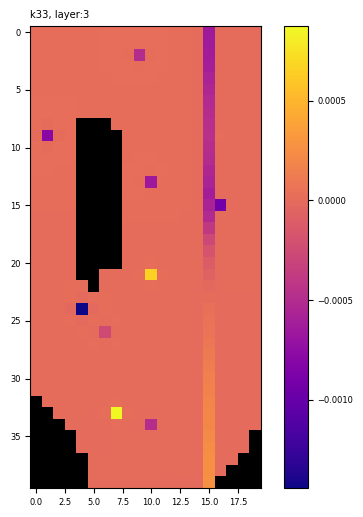

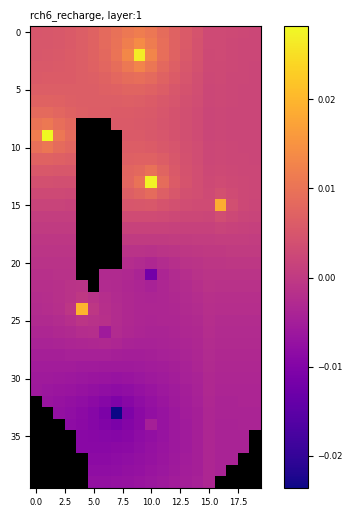

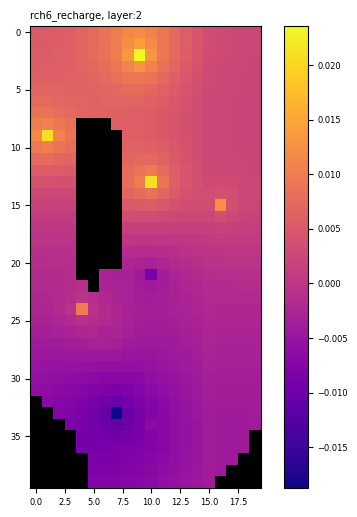

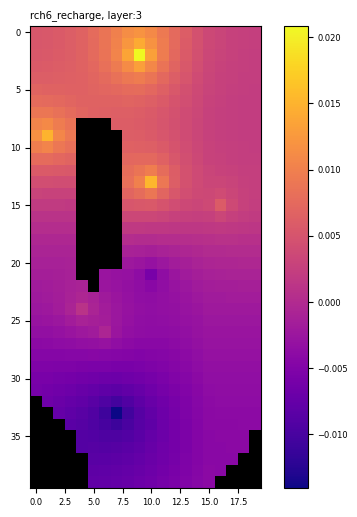

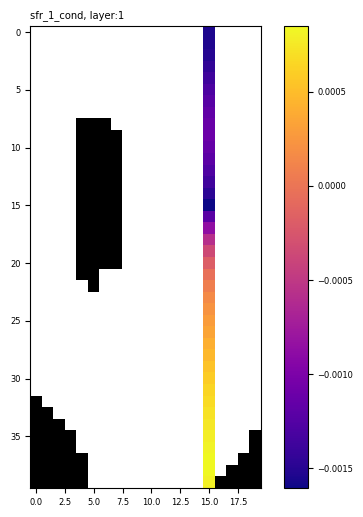

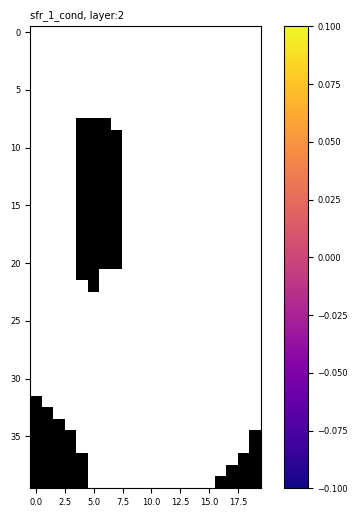

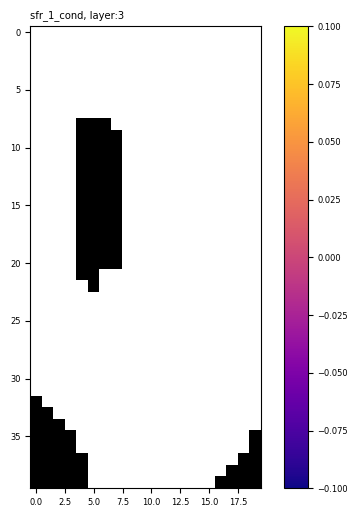

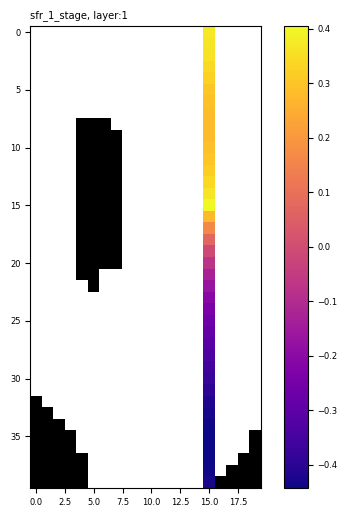

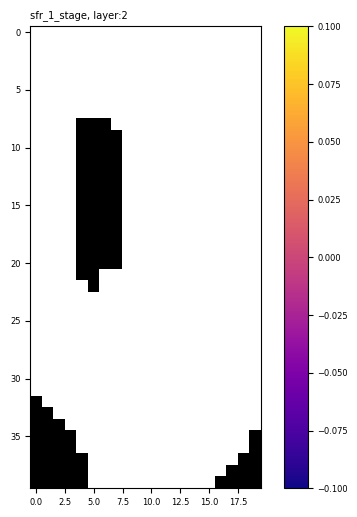

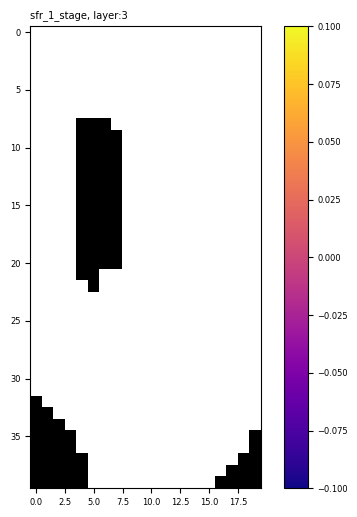

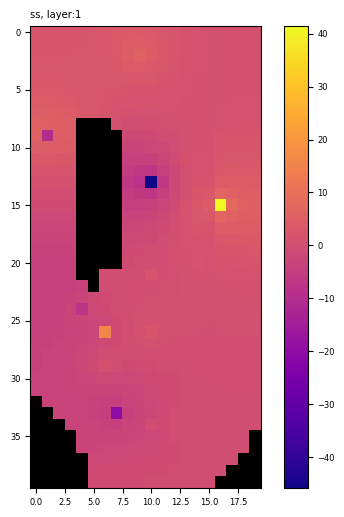

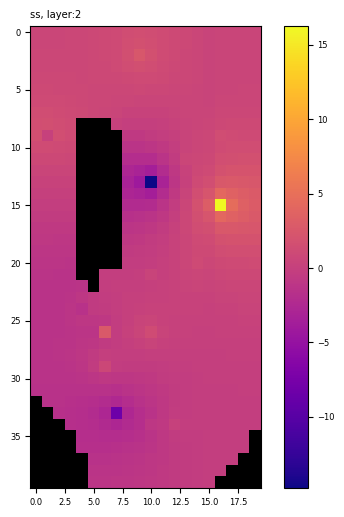

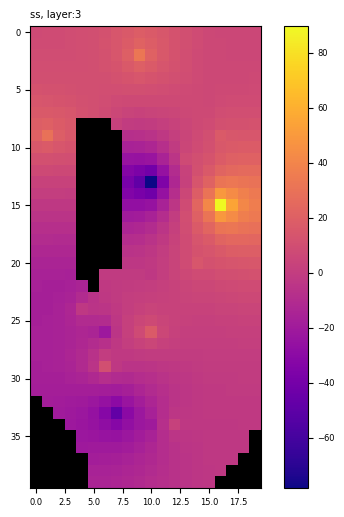

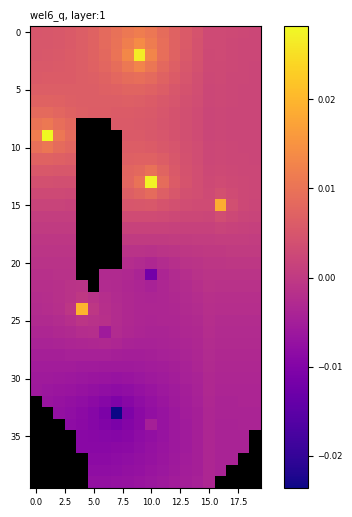

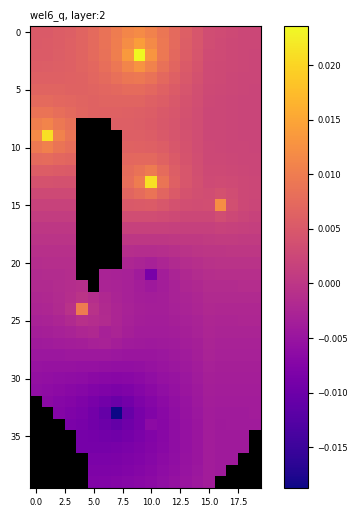

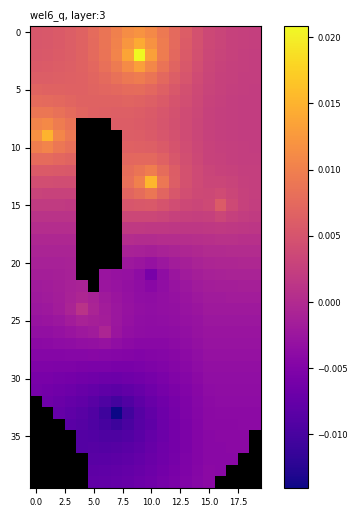

In [33]:
result_hdf = "adjoint_solution_pm_ssr_forward.hdf5"
hdf = h5py.File(os.path.join(ws,result_hdf),'r')
keys = list(hdf.keys())
grp = hdf["composite"]
plot_keys = [i for i in grp.keys() if len(grp[i].shape) == 3]
for pkey in plot_keys:
    arr = grp[pkey][:]
    for k,karr in enumerate(arr):
        karr[karr==0.0] = np.nan
        fig,ax = plot_model(karr)
        ax.set_title(pkey+", layer:{0}".format(k+1),loc="left")